In [2]:
pip install shapely

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 4.0 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 3.2 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import ast
import numpy as np
from shapely.geometry import Polygon
from collections import defaultdict
%matplotlib inline

def parse_points(points_str):
    try:
        #Convert string list to actual list
        pts = ast.literal_eval(points_str)
        if len(pts) < 3: return None
        return Polygon(pts)
    except:
        return None
    

def load_dataset(file_path):
    file_path = 'data/processed/wildtrack.csv'
    df = pd.read_csv(file_path)

    #identify the correct column names based on dataset type
    t_col = 'timestep' if 'timestep' in df.columns else 'frame'
    id_col = 'object'

    frames = {}
    for t in sorted(df[t_col].unique()):
        frame_df = df[df[t_col] == t]
        frame_objects = {}
        for _, row in frame_df.iterrows():
            poly = parse_points(row['points'])
            if poly:
                frame_objects[str(row[id_col])] = {
                    'poly': poly,
                    'y': row['ycenter'],
                    'area': row['area'],
                    'id': str(row[id_col])
                }
        frames[t] = frame_objects
    return frames

In [2]:
class MoReVisExtension:
    def __init__(self, iou_threshold=0.5):
        self.iou_threshold = iou_threshold
    
    def get_iou(self, p1, p2):
        if not p1.intersects(p2): return 0
        inter = p1.intersection(p2).area
        union = p1.area + p2.area - inter
        return inter / union if union > 0 else 0
    
    def analyze(self, frames):
        events = {'splits': [], 'merges': [], 'collisions': []}
        timesteps = sorted(frames.keys())

        for i in range(len(timesteps)):
            t = timesteps[i]
            objs = frames[t]

            #1. Collision detection (same timestep)
            obj_ids = list(objs.keys())
            for idx1 in range(len(obj_ids)):
                for idx2 in range(idx1 + 1, len(obj_ids)):
                    id1, id2 = obj_ids[idx1], obj_ids[idx2]
                    if objs[id1]['poly'].intersects(objs[id2]['poly']):
                        events['collisions'].append({
                            'timestep': t, 
                            'objects': (id1, id2),
                            'area': objs[id1]['poly'].intersection(objs[id2]['poly']).area
                        })

            #2. Splits and Merge Detection (Between t and t+1)
            if i < len(timesteps) - 1:
                t_next = timesteps[i+1]
                next_objs = frames[t_next]

                mapping = defaultdict(list) #prev -> next
                rev_mapping = defaultdict(list) #next -> prev

                for p_id, p_data in objs.items():
                    for n_id, n_data in next_objs.items():
                        if p_data['poly'].intersects(n_data['poly']):
                            if self.get_iou(p_data['poly'], n_data['poly']) > self.iou_threshold:
                                mapping[p_id].append(n_id)
                                rev_mapping[n_id].append(p_id)
                

                #To detect splits
                for p_id, children in mapping.items():
                    if len(children) > 1:
                        events['splits'].append({'t': t, 'parent': p_id, 'children': children})

                #To detect merges
                for n_id, parents in rev_mapping.items():
                    if len(parents) > 1:
                        events['merges'].append({'t': t+1, 'child': n_id, 'parents': parents})

        return events

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

def draw_morevis_summary(frames, events, title="MoReVis Summary"):
    fig, ax = plt.subplots(figsize=(15, 8))

    #Visual params
    colors = plt.cm.tab20.colors
    timesteps = sorted(frames.keys())

    for i in range(len(timesteps)-1):
        t, t_next = timesteps[i], timesteps[i+1]

        for obj_id, data in frames[t].items():
            y0, h0 = data['y'], np.sqrt(data['area'])

            #To find connections either standard or splitwise
            for next_id, next_data in frames[t_next].items():
                if data['poly'].intersects(next_data['poly']):
                    y1, h1 = next_data['y'], np.sqrt(next_data['area'])

                    #Uncertainty Visualization
                    alpha = min(1.0, data['area'] / 50000) if 'wildtrack' in title.lower() else 0.6

                    #Bezier ribbon
                    path_data = [
                        (Path.MOVETO, (t, y0 - h0/2)),
                        (Path.CURVE4, (t + 0.5, y0 - h0/2)),
                        (Path.CURVE4, (t_next - 0.5, y1 - h1/2)),
                        (Path.CURVE4, (t_next, y1 - h1/2)),
                        (Path.LINETO, (t_next, y1 - h1/2)),
                        (Path.CURVE4, (t_next - 0.5, y1 + h1/2)),
                        (Path.CURVE4, (t + 0.5, y0 + h0/2)),
                        (Path.CURVE4, (t, y0 + h0/2)),
                        (Path.CURVE4, (t, y0 - h0/2)),
                    ]
                    codes, verts = zip(*path_data)
                    color = colors[int(obj_id) % 20]
                    ax.add_patch(patches.PathPatch(Path(verts, codes), facecolor=color, alpha=alpha, lw=0))
    

    #To mark collisions
    for col in events['collisions']:
        t = col['timestep']
        obj_id = col['objects'][0]
        y_center = frames[t][obj_id]['y']
        ax.scatter(t, y_center, color='red', marker='x', s=50, zorder=10)

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Projected Space (Y-center)")
    plt.show()

Loaded 400 frames.
Detected 861 splits and 855 merges.


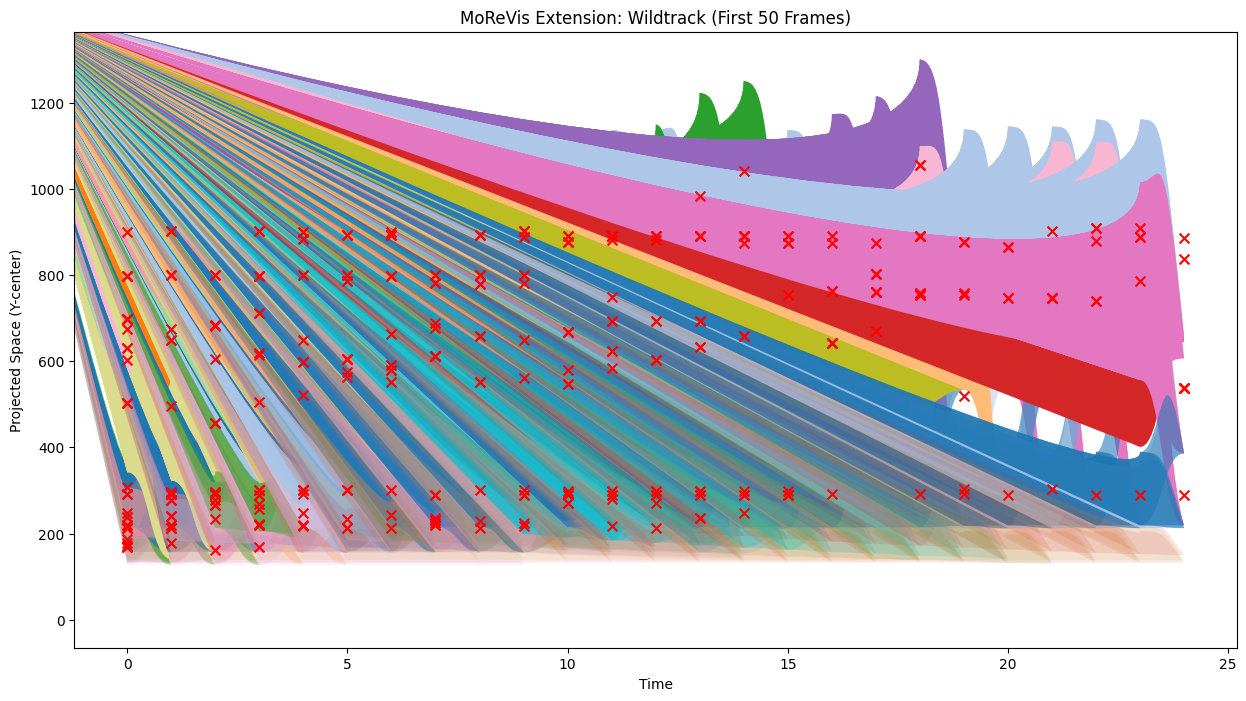

In [8]:
# 1. Load the data (Make sure the CSV is in the same folder as your notebook)
data = load_dataset('data/processed/wildtrack.csv')

# 2. Initialize the Extension logic
ext = MoReVisExtension(iou_threshold=0.5)
events = ext.analyze(data)

# 3. Print a summary to verify it's working
print(f"Loaded {len(data)} frames.")
print(f"Detected {len(events['splits'])} splits and {len(events['merges'])} merges.")

# 4. Generate the actual visual summary
#draw_morevis_summary(data, events, "MoReVis Extension: Wildtrack Analysis")

# Slice the data to show only the first 50 frames for clarity
data_slice = {t: data[t] for t in sorted(data.keys())[:25]}
events_slice = ext.analyze(data_slice)

draw_morevis_summary(data_slice, events_slice, "MoReVis Extension: Wildtrack (First 50 Frames)")